### Setup

In [1]:
import argparse
import numpy as np
from tqdm import tqdm
from pprint import pprint
import torchvision
import torch
import torch.nn.functional as F
from torch import autograd, nn, optim
from torch.nn import functional as F

# Latent dimensions
latent_dim = 10
# Training iterations
iter_max = 50
# Batch size
batch_size = 100
# For the optimizer
learning_rate = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
def get_mnist_data(device, batch_size):
    preprocess = torchvision.transforms.ToTensor()
    train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=True, download=True, transform=preprocess), batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('data', train=False, download=True, transform=preprocess), batch_size=batch_size, shuffle=True, num_workers=2)


    # Create pre-processed training and test sets
    X_train = train_loader.dataset.train_data.to(device).reshape(-1, 784).float() / 255
    y_train = train_loader.dataset.train_labels.to(device)
    X_test = test_loader.dataset.test_data.to(device).reshape(-1, 784).float() / 255
    y_test = test_loader.dataset.test_labels.to(device)
    # print(test_loader.dataset.test_data.size())

    # return train_loader, (X_test, y_test)
    return train_loader, test_loader

train_loader, test_loader = get_mnist_data(device, batch_size)
train_loader

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


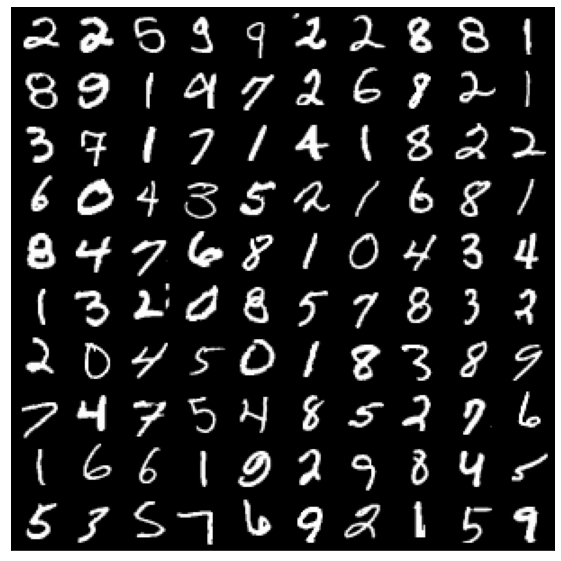

In [17]:
from matplotlib import pyplot as plt

def imshow(img):
    npimg = img.numpy()
    # print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(npimg)
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images, nrow = 10))

### Utility Functions

In [4]:
def gaussian_parameters(h, dim=-1):
    """
    Converts generic real-valued representations into mean and variance
    parameters of a Gaussian distribution

    Args:
        h: tensor: (batch, ..., dim, ...): Arbitrary tensor
        dim: int: (): Dimension along which to split the tensor for mean and
            variance

    Returns:
        m: tensor: (batch, ..., dim / 2, ...): Mean
        v: tensor: (batch, ..., dim / 2, ...): Variance
    """
    m, h = torch.split(h, h.size(dim) // 2, dim=dim)
    v = F.softplus(h) + 1e-8
    return m, v


def sample_gaussian(m, v):
    """
    Element-wise application reparameterization trick to sample from Gaussian

    Args:
        m: tensor: (batch, ...): Mean
        v: tensor: (batch, ...): Variance

    Return:
        z: tensor: (batch, ...): Samples
    """
    std = torch.exp(0.5 * torch.log(v))
    eps = torch.randn_like(std)
    z = m + std*eps

    return z


bce = torch.nn.BCEWithLogitsLoss(reduction='none')


def log_bernoulli_with_logits(x, logits):
    """
    Computes the log probability of a Bernoulli given its logits

    Args:
        x: tensor: (batch, dim): Observation
        logits: tensor: (batch, dim): Bernoulli logits

    Return:
        log_prob: tensor: (batch,): log probability of each sample
    """
    log_prob = bce(input=logits, target=x).sum(-1)
    return log_prob


def kl_normal(qm, qv, pm, pv):
    """
    Computes the elem-wise KL divergence between two normal distributions KL(q || p) and
    sum over the last dimension

    Args:
        qm: tensor: (batch, dim): q mean
        qv: tensor: (batch, dim): q variance
        pm: tensor: (batch, dim): p mean
        pv: tensor: (batch, dim): p variance

    Return:
        kl: tensor: (batch,): kl between each sample
    """
    element_wise = 0.5 * (torch.log(pv) - torch.log(qv) + qv / pv + (qm - pm).pow(2) / pv - 1)
    kl = element_wise.sum(-1)
    return kl

### Base Models

In [5]:
class Encoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 2 * z_dim),
        )

    def encode(self, x, y=None):
        xy = x if y is None else torch.cat((x, y), dim=1)
        h = self.net(xy)
        m, v = gaussian_parameters(h, dim=1)
        return m, v

class Decoder(nn.Module):
    def __init__(self, z_dim, y_dim=0):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 300),
            nn.ELU(),
            nn.Linear(300, 300),
            nn.ELU(),
            nn.Linear(300, 784)
        )

    def decode(self, z, y=None):
        zy = z if y is None else torch.cat((z, y), dim=1)
        return self.net(zy)


### VAE Model

In [6]:
class VAE(nn.Module):
    def __init__(self, name = 'vae', z_dim = 2):
        super().__init__()
        self.name = name
        self.z_dim = z_dim
        self.enc = Encoder(self.z_dim)
        self.dec = Decoder(self.z_dim)

        # Set prior as fixed parameter attached to Module
        self.z_prior_m = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.z_prior_v = torch.nn.Parameter(torch.ones(1), requires_grad=False)
        self.z_prior = (self.z_prior_m, self.z_prior_v)


    def loss(self, x):
        """
        Computes the Evidence Lower Bound, KL and, Reconstruction costs

        Args:
            x: tensor: (batch, dim): Observations

        Returns:
            nelbo: tensor: (): Negative evidence lower bound
            kl: tensor: (): ELBO KL divergence to prior
            rec: tensor: (): ELBO Reconstruction term
        """

        #Forward pass
        m, v = self.enc.encode(x.view(-1, 784))
        z = sample_gaussian(m, v)
        x_r = self.dec.decode(z)

        #KL
        kl = -0.5 * torch.sum(1 + torch.log(v) - m.pow(2) - torch.log(v).exp())

        #Rec
        rec = torch.sum(log_bernoulli_with_logits(x.view(-1, 784), x_r))

        nelbo = 0.01 * (kl + rec)
        return nelbo, kl, rec

    def sample_sigmoid(self, batch):
        z = self.sample_z(batch)
        return self.compute_sigmoid_given(z)

    def compute_sigmoid_given(self, z):
        logits = self.dec.decode(z)
        return torch.sigmoid(logits)

    def sample_z(self, batch):
        return sample_gaussian(
            self.z_prior[0].expand(batch, self.z_dim),
            self.z_prior[1].expand(batch, self.z_dim))

    def sample_x(self, batch):
        z = self.sample_z(batch)
        return self.sample_x_given(z)

    def sample_x_given(self, z):
        return torch.bernoulli(self.compute_sigmoid_given(z))


### Run model

# Training:

In [7]:
vae = VAE(z_dim = latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
train_loss = []
kl_arr = []
rec_arr = []
for i in tqdm(range(iter_max)):
  vae.train()
  for batch_idx, (xu, _) in enumerate(train_loader):
      xu = xu.to(device)
      optimizer.zero_grad()

      loss, kl, rec = vae.loss(xu)
      loss.backward()
      optimizer.step()

  print('Train set loss:{}'.format(loss))
  train_loss = np.append(train_loss ,loss.item())
  kl_arr = np.append(kl_arr , kl.item())
  rec_arr = np.append(rec_arr , rec.item())

  2%|▏         | 1/50 [00:26<21:33, 26.39s/it]

Train set loss:132.07362365722656


  4%|▍         | 2/50 [00:39<14:39, 18.32s/it]

Train set loss:112.81305694580078


  6%|▌         | 3/50 [00:51<12:17, 15.69s/it]

Train set loss:119.85066986083984


  8%|▊         | 4/50 [01:04<11:07, 14.51s/it]

Train set loss:111.65536499023438


 10%|█         | 5/50 [01:16<10:23, 13.85s/it]

Train set loss:108.14468383789062


 12%|█▏        | 6/50 [01:29<09:53, 13.49s/it]

Train set loss:104.40238189697266


 14%|█▍        | 7/50 [01:43<09:46, 13.63s/it]

Train set loss:110.53475189208984


 16%|█▌        | 8/50 [01:56<09:20, 13.35s/it]

Train set loss:112.39283752441406


 18%|█▊        | 9/50 [02:09<08:58, 13.14s/it]

Train set loss:106.18387603759766


 20%|██        | 10/50 [02:21<08:40, 13.00s/it]

Train set loss:105.14016723632812


 22%|██▏       | 11/50 [02:34<08:24, 12.93s/it]

Train set loss:101.91476440429688


 24%|██▍       | 12/50 [02:47<08:10, 12.92s/it]

Train set loss:104.34701538085938


 26%|██▌       | 13/50 [03:00<07:56, 12.87s/it]

Train set loss:105.62493133544922


 28%|██▊       | 14/50 [03:13<07:45, 12.94s/it]

Train set loss:109.60386657714844


 30%|███       | 15/50 [03:34<08:58, 15.38s/it]

Train set loss:106.09140014648438


 32%|███▏      | 16/50 [03:47<08:17, 14.62s/it]

Train set loss:105.00078582763672


 34%|███▍      | 17/50 [04:00<07:44, 14.08s/it]

Train set loss:104.32205963134766


 36%|███▌      | 18/50 [04:12<07:18, 13.71s/it]

Train set loss:98.44340515136719


 38%|███▊      | 19/50 [04:25<06:57, 13.46s/it]

Train set loss:102.0450210571289


 40%|████      | 20/50 [04:38<06:38, 13.27s/it]

Train set loss:105.68869018554688


 42%|████▏     | 21/50 [04:52<06:30, 13.45s/it]

Train set loss:101.7906265258789


 44%|████▍     | 22/50 [05:05<06:12, 13.31s/it]

Train set loss:105.57781219482422


 46%|████▌     | 23/50 [05:18<05:55, 13.17s/it]

Train set loss:97.39735412597656


 48%|████▊     | 24/50 [05:31<05:41, 13.12s/it]

Train set loss:104.42394256591797


 50%|█████     | 25/50 [05:44<05:26, 13.05s/it]

Train set loss:100.3548355102539


 52%|█████▏    | 26/50 [05:57<05:12, 13.02s/it]

Train set loss:100.38578796386719


 54%|█████▍    | 27/50 [06:10<04:58, 12.98s/it]

Train set loss:106.20519256591797


 56%|█████▌    | 28/50 [06:22<04:44, 12.94s/it]

Train set loss:97.09497833251953


 58%|█████▊    | 29/50 [06:35<04:31, 12.95s/it]

Train set loss:103.56704711914062


 60%|██████    | 30/50 [06:48<04:19, 12.96s/it]

Train set loss:96.44554138183594


 62%|██████▏   | 31/50 [07:01<04:06, 12.98s/it]

Train set loss:99.28684997558594


 64%|██████▍   | 32/50 [07:14<03:53, 12.95s/it]

Train set loss:97.88954162597656


 66%|██████▌   | 33/50 [07:27<03:40, 12.98s/it]

Train set loss:98.4107437133789


 68%|██████▊   | 34/50 [07:41<03:29, 13.09s/it]

Train set loss:105.22103118896484


 70%|███████   | 35/50 [07:54<03:16, 13.08s/it]

Train set loss:102.13005828857422


 72%|███████▏  | 36/50 [08:07<03:02, 13.03s/it]

Train set loss:97.5518798828125


 74%|███████▍  | 37/50 [08:19<02:48, 12.94s/it]

Train set loss:98.18528747558594


 76%|███████▌  | 38/50 [08:32<02:35, 12.95s/it]

Train set loss:95.9269027709961


 78%|███████▊  | 39/50 [08:45<02:22, 12.93s/it]

Train set loss:96.71709442138672


 80%|████████  | 40/50 [08:58<02:09, 12.91s/it]

Train set loss:98.63711547851562


 82%|████████▏ | 41/50 [09:11<01:56, 12.97s/it]

Train set loss:97.52570343017578


 84%|████████▍ | 42/50 [09:25<01:44, 13.09s/it]

Train set loss:95.47630310058594


 86%|████████▌ | 43/50 [09:38<01:31, 13.05s/it]

Train set loss:97.70745086669922


 88%|████████▊ | 44/50 [09:51<01:18, 13.06s/it]

Train set loss:96.544921875


 90%|█████████ | 45/50 [10:04<01:05, 13.05s/it]

Train set loss:101.0770263671875


 92%|█████████▏| 46/50 [10:17<00:52, 13.06s/it]

Train set loss:97.60816192626953


 94%|█████████▍| 47/50 [10:30<00:39, 13.09s/it]

Train set loss:99.56941986083984


 96%|█████████▌| 48/50 [10:43<00:26, 13.07s/it]

Train set loss:101.2918701171875


 98%|█████████▊| 49/50 [10:56<00:12, 12.98s/it]

Train set loss:97.79833984375


100%|██████████| 50/50 [11:09<00:00, 13.38s/it]

Train set loss:101.6827392578125


#Train Statistics:

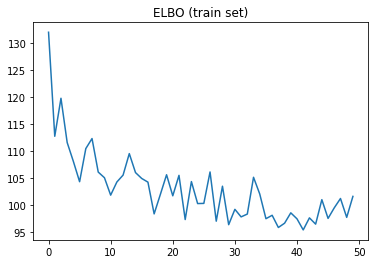

In [8]:
plt.plot(train_loss)
plt.title('ELBO (train set)')
plt.show()

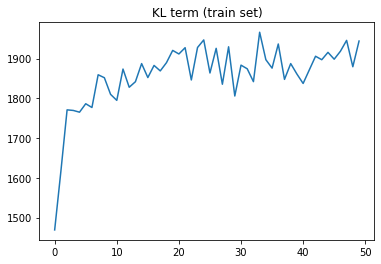

In [9]:
plt.plot(kl_arr)
plt.title('KL term (train set)')
plt.show()

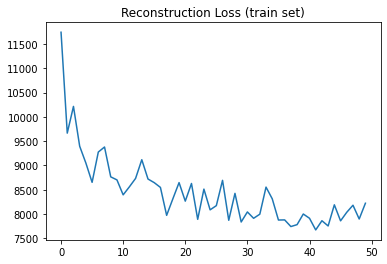

In [10]:
plt.plot(rec_arr)
plt.title('Reconstruction Loss (train set)')
plt.show()

# Testing:

In [11]:
test_loss = []
kl_arr_test = []
rec_arr_test = []
vae.eval()

for i in tqdm(range(iter_max)):
  with torch.no_grad():
      for xu, _ in test_loader:
          xu = xu.to(device)
          tloss, tkl, trec = vae.loss(xu)
      test_loss = np.append(test_loss ,tloss.item())
      kl_arr_test = np.append(kl_arr_test , tkl.item())
      rec_arr_test = np.append(rec_arr_test , trec.item())
      print('Test set loss: {}'.format(tloss))


  2%|▏         | 1/50 [00:01<01:12,  1.48s/it]

Test set loss: 102.54764556884766


  4%|▍         | 2/50 [00:02<01:10,  1.47s/it]

Test set loss: 103.2352523803711


  6%|▌         | 3/50 [00:04<01:08,  1.47s/it]

Test set loss: 100.67820739746094


  8%|▊         | 4/50 [00:05<01:07,  1.47s/it]

Test set loss: 100.08573913574219


 10%|█         | 5/50 [00:07<01:05,  1.47s/it]

Test set loss: 98.0721206665039


 12%|█▏        | 6/50 [00:08<01:04,  1.46s/it]

Test set loss: 100.22820281982422


 14%|█▍        | 7/50 [00:10<01:02,  1.46s/it]

Test set loss: 99.59417724609375


 16%|█▌        | 8/50 [00:11<01:01,  1.46s/it]

Test set loss: 102.62676239013672


 18%|█▊        | 9/50 [00:13<00:59,  1.46s/it]

Test set loss: 98.28216552734375


 20%|██        | 10/50 [00:14<00:58,  1.46s/it]

Test set loss: 97.6525650024414


 22%|██▏       | 11/50 [00:16<00:56,  1.46s/it]

Test set loss: 101.72916412353516


 24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

Test set loss: 100.86518096923828


 26%|██▌       | 13/50 [00:18<00:53,  1.46s/it]

Test set loss: 100.08667755126953


 28%|██▊       | 14/50 [00:20<00:52,  1.46s/it]

Test set loss: 109.65558624267578


 30%|███       | 15/50 [00:21<00:51,  1.46s/it]

Test set loss: 97.82936096191406


 32%|███▏      | 16/50 [00:23<00:49,  1.45s/it]

Test set loss: 105.67210388183594


 34%|███▍      | 17/50 [00:24<00:47,  1.44s/it]

Test set loss: 101.6381607055664


 36%|███▌      | 18/50 [00:26<00:46,  1.46s/it]

Test set loss: 105.45343780517578


 38%|███▊      | 19/50 [00:27<00:45,  1.45s/it]

Test set loss: 100.34392547607422


 40%|████      | 20/50 [00:29<00:43,  1.47s/it]

Test set loss: 101.27734375


 42%|████▏     | 21/50 [00:30<00:42,  1.48s/it]

Test set loss: 97.26924896240234


 44%|████▍     | 22/50 [00:32<00:41,  1.48s/it]

Test set loss: 105.3266372680664


 46%|████▌     | 23/50 [00:33<00:39,  1.48s/it]

Test set loss: 102.73096466064453


 48%|████▊     | 24/50 [00:35<00:38,  1.48s/it]

Test set loss: 103.55355072021484


 50%|█████     | 25/50 [00:36<00:36,  1.48s/it]

Test set loss: 104.62675476074219


 52%|█████▏    | 26/50 [00:38<00:35,  1.48s/it]

Test set loss: 96.98180389404297


 54%|█████▍    | 27/50 [00:39<00:33,  1.47s/it]

Test set loss: 96.57564544677734


 56%|█████▌    | 28/50 [00:41<00:32,  1.46s/it]

Test set loss: 103.22572326660156


 58%|█████▊    | 29/50 [00:42<00:30,  1.47s/it]

Test set loss: 102.43462371826172


 60%|██████    | 30/50 [00:43<00:29,  1.47s/it]

Test set loss: 102.58576965332031


 62%|██████▏   | 31/50 [00:45<00:27,  1.47s/it]

Test set loss: 98.08231353759766


 64%|██████▍   | 32/50 [00:46<00:26,  1.48s/it]

Test set loss: 100.90402221679688


 66%|██████▌   | 33/50 [00:48<00:25,  1.48s/it]

Test set loss: 102.67717742919922


 68%|██████▊   | 34/50 [00:49<00:23,  1.48s/it]

Test set loss: 98.33699035644531


 70%|███████   | 35/50 [00:51<00:22,  1.48s/it]

Test set loss: 100.96742248535156


 72%|███████▏  | 36/50 [00:52<00:20,  1.49s/it]

Test set loss: 98.76888275146484


 74%|███████▍  | 37/50 [00:54<00:19,  1.48s/it]

Test set loss: 101.50540924072266


 76%|███████▌  | 38/50 [00:55<00:17,  1.48s/it]

Test set loss: 100.47720336914062


 78%|███████▊  | 39/50 [00:57<00:16,  1.48s/it]

Test set loss: 99.40846252441406


 80%|████████  | 40/50 [00:58<00:14,  1.48s/it]

Test set loss: 104.82791900634766


 82%|████████▏ | 41/50 [01:00<00:13,  1.47s/it]

Test set loss: 104.56885528564453


 84%|████████▍ | 42/50 [01:01<00:11,  1.46s/it]

Test set loss: 102.84524536132812


 86%|████████▌ | 43/50 [01:03<00:10,  1.46s/it]

Test set loss: 98.21502685546875


 88%|████████▊ | 44/50 [01:04<00:08,  1.45s/it]

Test set loss: 101.2186279296875


 90%|█████████ | 45/50 [01:06<00:07,  1.45s/it]

Test set loss: 102.65084075927734


 92%|█████████▏| 46/50 [01:07<00:05,  1.45s/it]

Test set loss: 97.6280517578125


 94%|█████████▍| 47/50 [01:08<00:04,  1.46s/it]

Test set loss: 103.19833374023438


 96%|█████████▌| 48/50 [01:10<00:02,  1.46s/it]

Test set loss: 99.8321304321289


 98%|█████████▊| 49/50 [01:11<00:01,  1.46s/it]

Test set loss: 100.54155731201172


100%|██████████| 50/50 [01:13<00:00,  1.47s/it]

Test set loss: 100.25261688232422


# Test Statistics:

(50,)


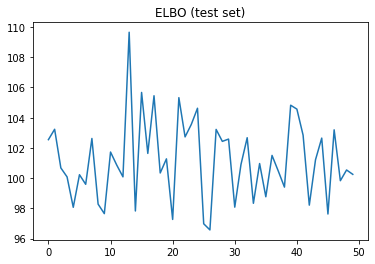

In [12]:
print(test_loss.shape)
plt.plot(test_loss)
plt.title('ELBO (test set)')
plt.show()

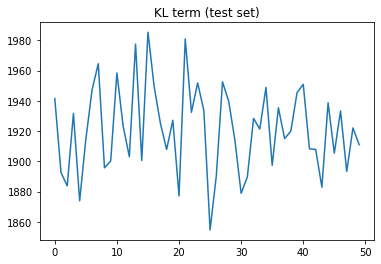

In [13]:
plt.plot(kl_arr_test)
plt.title('KL term (test set)')
plt.show()

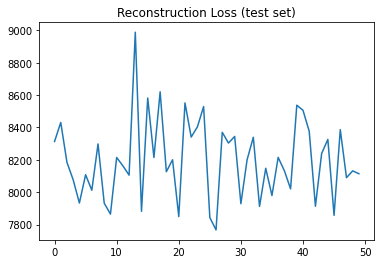

In [16]:
plt.plot(rec_arr_test)
plt.title('Reconstruction Loss (test set)')
plt.show()

# Generating 100 MNIST numbers:

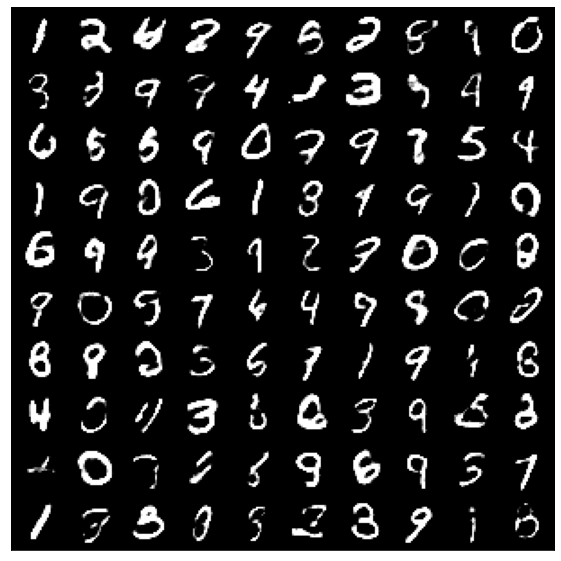

In [18]:
with torch.no_grad():
    z = torch.randn(100, 10).to(device)
    sample = vae.dec.decode(z).to(device)

    imshow(torchvision.utils.make_grid(sample.view(100, 1, 28, 28),nrow=10))
    # torchvision.utils.save_image(sample.view(100, 1, 28, 28), './sample_' + '.png')
